# Tourenplanung für Ride-Sharing-Dienstleister

In [47]:
import numpy as np
import copy
from datetime import datetime
import numpy as np
import plotly.figure_factory as ff
import pandas as pd
import matplotlib.pyplot as plt

### Klasse Request

In [48]:
#Aufrunden?

def euclidean(loc1, loc2):
    return ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**0.5

In [49]:
class Request:
    
    def __init__(self, orig_loc, dest_loc, req_t, alpha):
        self.orig_loc = orig_loc
        self.dest_loc = dest_loc
        self.req_t = req_t
        self.alpha = alpha # tolerierte Wartezeit
        self.end_t = req_t + euclidean(orig_loc, dest_loc) + alpha
    
    orig_earl = -1
    dest_earl = -1
    orig_late = -1
    dest_late = -1

Es gibt 3 Kunden, die an den Koordinaten (1,8), (6,5) und (3,2) zu- und an den Koordinaten (5,9), (3,4) und (8,5) aussteigen. Der folgende Graf zeigt die Anfangskoordinaten (blau) und Endkoordinaten (rot).

In [71]:
kunde1 = Request((1,8), (5,9), 0,10)
kunde2 = Request((6,5), (3,4), 0,10)
kunde3 = Request((3,2), (8,5), 0,10)
depot = Request((0,0),(0,0), 0,0)
depot.end_t = 100

In [51]:
knoten = [kunde1, kunde2, kunde3]

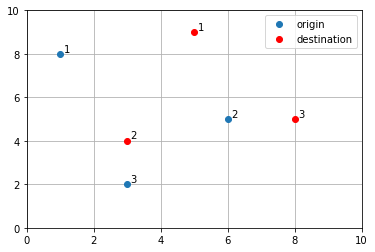

In [52]:
plt.plot([1,6,3],[8,5,2],'o', label ="origin")
plt.plot([5,3,8],[9,4,5],'ro', label = "destination")
plt.text((1+0.1),(8+0.1), 1)
plt.text((5+0.1),(9+0.1), 1)
plt.text((6+0.1),(5+0.1), 2)
plt.text((3+0.1),(4+0.1), 2)
plt.text((3+0.1),(2+0.1), 3)
plt.text((8+0.1),(5+0.1), 3)
plt.axis([0,10,0,10])
plt.grid()
plt.legend()
plt.show()

In [54]:
M = 1000 
#I = [0,1,2,3,4,5] #5 Kunden+Depot = Knoten
K = 2 #Anzahl Fahrzeuge = Anzahl Touren
#seed = [] #Vordefinierte Seed Customer
#startzeitfenster = [0, 20, 10, 50, 55, 70, 0]
#endezeitfenster = [100, 40, 35, 70, 65, 75,100]
#kundenOffen = copy.deepcopy(I)

Die Kosten einer Fahrt werden definiert, als die zurückgelegt Distanz. Diese wird duch die euklidische Distanz berechnet und entspricht gleichzeitig der zurückgelegten Zeit.

In [15]:
def c (o, d):
    d = ((o[0]-d[0])**2+(o[1]-d[1])**2)**0.5

In [72]:
tourenplaninit = []
tourenplaninit.append([depot,depot]) 
tourenplaninit.append([depot,depot])

In [73]:
tourenplaninit

[[<__main__.Request at 0x7f9edd9c6510>, <__main__.Request at 0x7f9edd9c6510>],
 [<__main__.Request at 0x7f9edd9c6510>, <__main__.Request at 0x7f9edd9c6510>]]

In [74]:
tourenplan = copy.deepcopy(tourenplaninit)

In [75]:
kunde1_s = Request(kunde1.orig_loc, kunde1.orig_loc, 0,10)
kunde1_s.end_t = kunde1.req_t+10
kunde1_e = Request(kunde1.dest_loc, kunde1.dest_loc, 0,10)
kunde1_e.req_t = kunde1.end_t-10

kunde2_s = Request(kunde2.orig_loc, kunde2.orig_loc, 0,10)
kunde2_s.end_t = kunde2.req_t+10
kunde2_e = Request(kunde2.dest_loc, kunde2.dest_loc, 0,10)
kunde2_e.req_t = kunde2.end_t-10

kunde3_s = Request(kunde3.orig_loc, kunde3.orig_loc, 0,10)
kunde3_s.end_t = kunde3.req_t+10
kunde3_e = Request(kunde3.dest_loc, kunde3.dest_loc, 0,10)
kunde3_e.req_t = kunde3.end_t-10

fiktivekunden = [[kunde1_s, kunde1_e], [kunde2_s, kunde2_e], [kunde3_s, kunde3_e]]

In [69]:
def parinsertion (tourenplan, fiktivekunden, M, K):
    reject = []
    Kunden = copy.deepcopy(fiktivekunden)
    
    #in jeder Iteration wird ein Kunde aus der Liste genommen, bis diese leer ist
    while Kunden != []:
        pOpt = M #initialisiert mit sehr hoher Zahl M
        for j in range(len(Kunden)):
        
            #K ist die Anzahl der Touren/Fahrzeuge
            for k in range(K): 
                  
                #spos ist die Position in Tour k, an der der Pickup des Kunden eingefügt wird
                for spos in range(1, len(tourenplan[k])): # iteriert von der zweiten bis zur vorletzen Position der Tour
                    
                    #Feasibility Check: Kann der Kunde an spos eingefügt werden ohne das ein Zeitfenster verpasst wird?    
                    e = max(Kunden[j][0].req_t,tourenplan[k][spos-1].req_t+euclidean(tourenplan[k][spos-1].orig_loc,Kunden[j][0].orig_loc))
                        
                    l = min(Kunden[j][0].end_t,tourenplan[k][spos].end_t-euclidean(tourenplan[k][spos].dest_loc,Kunden[j][0].dest_loc))
                    
                    if e <= l:
                          
                        skosten = euclidean(tourenplan[k][spos-1].dest_loc,Kunden[j][0].orig_loc)+euclidean(Kunden[j][0].dest_loc,tourenplan[k][spos].orig_loc)-euclidean(tourenplan[k][spos-1].dest_loc,tourenplan[k][spos].orig_loc)
                        
                        # speichert den aktuell gültigen tourenplan in einer temporären Variablen
                        tourenplantemp = copy.deepcopy(tourenplan)        
                        
                        # füge den Pickup des Kunden vorübergehend in den Tourenplan ein
                        tourenplan[k].insert(spos,Kunden[j][0])
                        
                        #Update die Start und Endzeitfenster
                        for i in range(spos, len(tourenplan[k])-1) :
                            tourenplan[k][i].req_t = max(tourenplan[k][i].req_t, tourenplan[k][i-1].req_t+euclidean(tourenplan[k][i].orig_loc,tourenplan[k][i-1].dest_loc))
                        for i in range(spos-1, 0, -1):
                            tourenplan[k][i].end_t = min(tourenplan[k][i].end_t, tourenplan[k][i+1].end_t-euclidean(tourenplan[k][i].dest_loc,tourenplan[k][i+1].orig_loc))
                        
                        # Prüfe für alle Positionen im Tourenplan nach dem eingefügten Pickup ob es einen möglichen Drop-off gibt 
                        for epos in range(spos+1, len(tourenplan[k])): 
                    
                    
                            e = max(Kunden[j][1].req_t,tourenplan[k][epos-1].req_t+euclidean(tourenplan[k][epos-1].orig_loc,Kunden[j][1].orig_loc))
                        
                            l = min(Kunden[j][1].end_t,tourenplan[k][epos].end_t-euclidean(tourenplan[k][epos].dest_loc,Kunden[j][1].dest_loc))
                    
                                
                            if e <= l:
                                # wenn ein möglicher Drop-off punkt für den Kunden gefunden wird,
                                # und die gesamt kosten für den kunden kleiner aller bisherigen gefunden Kosten sind: Lösung merken 
                                    ekosten = euclidean(tourenplan[k][epos-1].dest_loc,Kunden[j][1].orig_loc)+euclidean(Kunden[j][1].dest_loc,tourenplan[k][epos].orig_loc)-euclidean(tourenplan[k][epos-1].dest_loc,tourenplan[k][epos].orig_loc)
  
                                    if  skosten + ekosten < pOpt: #Verwende die "optimale" Lösung
                                        jOpt = j
                                        kOpt = k
                                        sposOpt = spos
                                        eposOpt = epos
                                        pOpt = skosten + ekosten
                            
                        #tourenplan wird auf den vorher gültigen tourenplan zurückgesetzt
                        tourenplan = copy.deepcopy(tourenplantemp)     
      
        if pOpt < M:   
            #Setze denn "optimalen" Kunden, an der "optimalen" Posititon im "optimalen" Tourenplan ein
            
            #Setze den Pickup des Kunden ein
            tourenplan[kOpt].insert(sposOpt,Kunden[jOpt][0]) 
            
            #Update die Start- und Endzeitfenster
            for i in range(sposOpt, len(tourenplan[kOpt])-1):
                    tourenplan[kOpt][i].req_t = max(tourenplan[kOpt][i].req_t, tourenplan[kOpt][i-1].req_t+euclidean(tourenplan[kOpt][i].orig_loc,tourenplan[kOpt][i-1].dest_loc))
            for i in range(sposOpt-1, 0, -1):
                    tourenplan[kOpt][i].end_t = min(tourenplan[kOpt][i].end_t, tourenplan[kOpt][i+1].end_t-euclidean(tourenplan[kOpt][i].dest_loc,tourenplan[kOpt][i+1].orig_loc))
            
            #Setze den Drop-off des Kunden ein
            tourenplan[kOpt].insert(eposOpt,Kunden[jOpt][1])
            
            #Update die Start- und Endzeitfenster 
            for i in range(eposOpt, len(tourenplan[kOpt])-1):
                    tourenplan[kOpt][i].req_t = max(tourenplan[kOpt][i].req_t, tourenplan[kOpt][i-1].req_t+euclidean(tourenplan[kOpt][i].orig_loc,tourenplan[kOpt][i-1].dest_loc))
            for i in range(eposOpt-1, 0, -1):
                    tourenplan[kOpt][i].end_t = min(tourenplan[kOpt][i].end_t, tourenplan[kOpt][i+1].end_t-euclidean(tourenplan[kOpt][i].dest_loc,tourenplan[kOpt][i+1].orig_loc))
            
            #Entferne den eigesetzten Kunden aus der Liste der noch ausstehenden Kunden
            Kunden.remove(Kunden[jOpt]) 
        
        else:
            # Wenn keine Kunde den Feasibility mehr besteht, speichere die abgewiesenen Kunden und leere die Liste
            reject = copy.deepcopy(Kunden)
            Kunden = []
   
    return tourenplan,reject

In [76]:
opttourenplan, reject  = parinsertion(tourenplaninit, fiktivekunden, M, K)
print(opttourenplan)
print(reject)

[[<__main__.Request object at 0x7f9edd9c6e90>, <__main__.Request object at 0x7f9edd9c6f90>, <__main__.Request object at 0x7f9edd9edc10>, <__main__.Request object at 0x7f9edd9c6e90>], [<__main__.Request object at 0x7f9edd9c6e90>, <__main__.Request object at 0x7f9edd9c6e90>]]
[[<__main__.Request object at 0x7f9edebcd310>, <__main__.Request object at 0x7f9edd9ed050>], [<__main__.Request object at 0x7f9edd9ed490>, <__main__.Request object at 0x7f9edf5df250>]]


In [ ]:
gesamtkost = 0
for k in range(K):
    tourkost = 0
    for pos in range(len(opttourenplan[k])-1):
        tourkost = tourkost + c[opttourenplan[k][pos],opttourenplan[k][pos+1]]
    gesamtkost = gesamtkost + tourkost 
print(gesamtkost) 

### GANTT CHART

In [ ]:
def convert_to_datetime(x):
      return datetime.fromtimestamp(31536000+x*24*3600).strftime("%Y-%m-%d")

In [ ]:
start = copy.deepcopy(startzeitfenster[:-1])
ende = copy.deepcopy(endezeitfenster[:-1])

In [ ]:
for j in range(len(start)):
    start[j] = convert_to_datetime(start[j])
    ende[j] = convert_to_datetime(ende[j])

In [ ]:
num_tick_labels = np.linspace(start = 0, stop = 100, num = 21, dtype = int)
date_ticks = [convert_to_datetime(x) for x in num_tick_labels]

In [ ]:
df = pd.DataFrame({'Kunde': I, "Start": start , "Finish": ende})

In [ ]:
fig = ff.create_gantt(df)
fig.layout.xaxis.update({
        'tickvals' : date_ticks,
        'ticktext' : num_tick_labels
        })
fig.update_yaxes(autorange="reversed")
fig.show()

In [ ]:
for i in range(posOpt, len(tourenplan[kOpt])):
    print(i)

In [ ]:
import plotly.express as px
fig2 = px.timeline(df, x_start="Start", x_end="Finish", y="Kunde")
fig2.layout.xaxis.update({
        'tickvals' : date_ticks,
        'ticktext' : num_tick_labels
        })
fig2.update_yaxes(autorange="reversed")
fig2.show()